### **HIVE scRNAseq Analysis v1.3.2** ###
#### **Honeycomb Bioinformatics Team** ####
2023-10-06

#### **1 HIVE scRNAseq Analysis Vignette** ####
The document contains code and instructions to analyze single cell sequencing data generated by HIVE scRNAseq Solution. This analysis is intended as guidance to perform quality control, basic clustering and cell annotation for one experiments worth of samples. This example experiment has four samples where 7.5k or 30k cells were loaded into two HIVEs each (4 total HIVEs).

Please contact support@honeycomb.bio for all questions.

The below packages need to be installed prior to running this code. There may be additional dependencies required by these packages you may have to install depending on your R environment.

In [1]:
# suppressPackageStartupMessages({
# library(tidyverse)
# library(patchwork)
# library(plyr)
# library(Seurat)
# library(UCell)
# library(ggpubr)
# library(SingleCellExperiment)
# library(scuttle)
# library(celldex)
# library(DT)
# library(scales)
# library(UCell)
# library(HGNChelper)
# library(openxlsx)
# })

#### **1.1 Finding Count Matrices and Setting Up Metadata** ####
Be sure that you specify the correct path to your count matrices, readQC, and sample QC files. If these files are not located in the current working directory, please provide the full path in quotation marks in the code below.

We recommend making a unique folder for your analysis. In this folder, we recommend making subfolders for each sample that contain all of the files necessary for this analysis. Here is an example of our recommended file tree, and the file tree that this tutorial is written for:




Please enter the sample names into the sampleslist argument below. The sample names in this list must match the sample names in the BeeNet output files. For example, if the transcription count matrix file is named MySample1_20230426182713_TCM.tsv.gz, then your sample name is MySample1. Furthermore, if you would like to compare samples based on a particular metadata, enter that metadata into the “groupslist”. Order matters! In this example, samples 1 and 2 were loaded with 7.5k cells, and samples 3 and 4 were loaded with 30k cells. Be sure to preserve the order when entering this data.

In [2]:
from pathlib import Path

# Set the paths to the directories containing your files
base_path_1 = "/media/asus/275dd380-2319-4638-bcdd-5f65b2b1d4b5/CHRF_Project_Data/Single_Cell/Honeycomb_Biotechnologies/Data_Analysis/3_Additional_Analysis_Resources/1_Example_Data_for_BeeNetPLUS/1_Practice_running_BeeNetPLUS_using_this_dataset/BeeNetOutputs/Beenet_SC_NP_H_7061"
base_path_2 = "/media/asus/275dd380-2319-4638-bcdd-5f65b2b1d4b5/CHRF_Project_Data/Single_Cell/Honeycomb_Biotechnologies/Data_Analysis/3_Additional_Analysis_Resources/1_Example_Data_for_BeeNetPLUS/1_Practice_running_BeeNetPLUS_using_this_dataset/BeeNetOutputs/Beenet_SC_NP_H_7063"

# Combine both base paths into a list
base_paths = [base_path_1, base_path_2]

# Initialize empty lists to store file paths
CM_files = []
reads_files = []
samples_files = []

# Iterate over each base path
for base_path in base_paths:
    # Transcript count matrix files
    CM_files_tmp = list(Path(base_path).glob("*TCM.tsv.gz"))
    CM_files.extend(CM_files_tmp)

    # ReadsQC files
    reads_files_tmp = list(Path(base_path).glob("*ReadsQC.tsv"))
    reads_files.extend(reads_files_tmp)

    # SampleQC files
    samples_files_tmp = list(Path(base_path).glob("*SampleQC.tsv"))
    samples_files.extend(samples_files_tmp)

# Print the lists of files
print("Transcript count matrix files:")
print(CM_files)

print("ReadsQC files:")
print(reads_files)

print("SampleQC files:")
print(samples_files)

# Replace sample names below with the name of your sample. Make sure that the order of the samples and the order of the groups are correct!
samples_list = ["SC_NP_H_7061", "SC_NP_H_7063"]
groups_list = ["15k", "15k"]

# Print the lists of samples and groups
print("Sample list:")
print(samples_list)

print("Groups list:")
print(groups_list)


Transcript count matrix files:
[PosixPath('/media/asus/275dd380-2319-4638-bcdd-5f65b2b1d4b5/CHRF_Project_Data/Single_Cell/Honeycomb_Biotechnologies/Data_Analysis/3_Additional_Analysis_Resources/1_Example_Data_for_BeeNetPLUS/1_Practice_running_BeeNetPLUS_using_this_dataset/BeeNetOutputs/Beenet_SC_NP_H_7061/SC_NP_H_7061_20240125112551_TCM.tsv.gz'), PosixPath('/media/asus/275dd380-2319-4638-bcdd-5f65b2b1d4b5/CHRF_Project_Data/Single_Cell/Honeycomb_Biotechnologies/Data_Analysis/3_Additional_Analysis_Resources/1_Example_Data_for_BeeNetPLUS/1_Practice_running_BeeNetPLUS_using_this_dataset/BeeNetOutputs/Beenet_SC_NP_H_7063/SC_NP_H_7063_20240125114410_TCM.tsv.gz')]
ReadsQC files:
[PosixPath('/media/asus/275dd380-2319-4638-bcdd-5f65b2b1d4b5/CHRF_Project_Data/Single_Cell/Honeycomb_Biotechnologies/Data_Analysis/3_Additional_Analysis_Resources/1_Example_Data_for_BeeNetPLUS/1_Practice_running_BeeNetPLUS_using_this_dataset/BeeNetOutputs/Beenet_SC_NP_H_7061/SC_NP_H_7061_20240125112551_ReadsQC.tsv'), 

You should now see a list of your count matrices files and your readsQC files in your R environment

##### **1.2 Read Count Matrices and Create a Seurat Object for each sample** #####
Here we define a function called generate_seurat_object() to create Seurat objects from the BeeNet Outputs. This function reads in count matrices and adds metadata to your Seurat object.

In [19]:
from pathlib import Path
import pandas as pd
import scanpy as sc

# Set the paths to the directories containing your files
base_path_1 = "/media/asus/275dd380-2319-4638-bcdd-5f65b2b1d4b5/CHRF_Project_Data/Single_Cell/Honeycomb_Biotechnologies/Data_Analysis/3_Additional_Analysis_Resources/1_Example_Data_for_BeeNetPLUS/1_Practice_running_BeeNetPLUS_using_this_dataset/BeeNetOutputs/Beenet_SC_NP_H_7061"
base_path_2 = "/media/asus/275dd380-2319-4638-bcdd-5f65b2b1d4b5/CHRF_Project_Data/Single_Cell/Honeycomb_Biotechnologies/Data_Analysis/3_Additional_Analysis_Resources/1_Example_Data_for_BeeNetPLUS/1_Practice_running_BeeNetPLUS_using_this_dataset/BeeNetOutputs/Beenet_SC_NP_H_7063"

# Combine both base paths into a list
base_paths = [base_path_1, base_path_2]

# Initialize empty lists to store file paths
CM_files = []
reads_files = []
samples_files = []

# Iterate over each base path
for base_path in base_paths:
    # Transcript count matrix files
    CM_files_tmp = list(Path(base_path).glob("*TCM.tsv.gz"))
    CM_files.extend(CM_files_tmp)

    # ReadsQC files
    reads_files_tmp = list(Path(base_path).glob("*ReadsQC.tsv"))
    reads_files.extend(reads_files_tmp)

    # SampleQC files
    samples_files_tmp = list(Path(base_path).glob("*SampleQC.tsv"))
    samples_files.extend(samples_files_tmp)

# Define sample names and group names
samples_list = ["SC_NP_H_7061", "SC_NP_H_7063"]
groups_list = ["15k", "15k"]

# Function to generate Seurat-like object
def generate_seurat_object(sample, group_name, CM_files, reads_files):
    # Find and load the count matrix file for the given sample
    CMfile_path = next((f for f in CM_files if sample in str(f)), None)
    if CMfile_path is None:
        raise FileNotFoundError(f"No count matrix file found for sample {sample}")
    dataTran = pd.read_csv(CMfile_path, sep="\t", header=0, index_col=0)

    # Find and load the read info file for the given sample
    readsFile_path = next((f for f in reads_files if sample in str(f)), None)
    if readsFile_path is None:
        raise FileNotFoundError(f"No reads file found for sample {sample}")
    dataReads = pd.read_csv(readsFile_path, sep="\t", header=0, index_col=0)

    # Process and add metadata
    reads = dataReads.loc[dataReads.index.isin(dataTran.columns)]
    adata = sc.AnnData(dataTran.T)
    adata.obs['sample'] = sample
    adata.obs['group'] = group_name
    adata.obs['total_counts'] = reads['TotalCounts']
    adata.obs['mapped_counts'] = reads['Mapped']
    # Add additional metadata processing as needed

    return adata

# Initialize a list to store Seurat-like objects
adata_list = []

# Generate Seurat-like object for each sample
for sample, group_name in zip(samples_list, groups_list):
    adata_sample = generate_seurat_object(sample, group_name, CM_files, reads_files)
    adata_list.append(adata_sample)

# Concatenate all Seurat-like objects into a single AnnData object
adata_full = sc.concat(adata_list, index_unique=None, join='outer')

# Ensure observation names are unique
adata_full.obs_names_make_unique()

# Additional processing can be added here as needed, such as normalization, scaling, clustering, etc.

# Save the combined AnnData object
adata_full.write("combined_adata.h5ad")

# Print statement to confirm completion
print("Data processing complete. Combined AnnData object saved.")


KeyError: 'TotalCounts'

In [17]:
# Before filtering, make sure observation names are unique
adata_full.obs_names_make_unique()


In [18]:
# Basic filtering - removing cells with extremely high or low gene counts
sc.pp.filter_cells(adata_full, min_genes=200)


/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


IndexError: index 89 is out of bounds for axis 0 with size 58

In [14]:
import pandas as pd
import numpy as np
import scanpy as sc

# Function to generate Seurat-like object
def generate_seurat_object(sample, group_name=""):
    # Replace these ellipses with the actual lists of file paths
    CMfile = ["path/to/CMfile_sample1.csv", "path/to/CMfile_sample2.csv", ...]
    readsFile = ["path/to/readsFile_sample1.csv", "path/to/readsFile_sample2.csv", ...]


    # Load count matrix file
    CMfile_path = next(f for f in CMfile if sample in f)
    dataTran = pd.read_csv(CMfile_path, sep="\t", header=0, index_col=0)

    # Load read info for each barcode
    readsFile_path = next(f for f in readsFile if sample in f)
    dataReads = pd.read_csv(readsFile_path, sep="\t", header=0, index_col=0)

    # Make sure order of read info matches order of TCM matrix
    reads = dataReads.loc[dataReads.index.isin(dataTran.columns)]

    # Create a Scanpy AnnData object
    adata = sc.AnnData(dataTran.T)

    # Calculate metadata info
    logtotreads = (reads.iloc[:, 0].apply(np.log10)).reindex(adata.obs_names)
    readAll = dataReads.iloc[:, 0].reindex(adata.obs_names)
    readMap = reads.iloc[:, 1].reindex(adata.obs_names)
    readMapPct = readMap / readAll
    readUnmap = readAll - readMap
    readUnmapPct = readUnmap / readAll
    readExon = reads.iloc[:, 2].reindex(adata.obs_names)
    readExonPct = readExon / readAll
    readExonMapPct = readExon / readMap

    # Add metadata to object
    adata.obs['Log_TotReads'] = logtotreads
    adata.obs['ExonvMapped'] = readExonMapPct
    adata.obs['ExonvTotal'] = readExonPct
    adata.obs['reads_mapped'] = readMap
    adata.obs['reads_Total'] = readAll
    adata.obs['ExonReads'] = readExon

    # Calculate n_counts (total counts per cell) and add to metadata
    adata.obs['n_counts'] = adata.X.sum(axis=1)

    # Calculate complexity and add to metadata
    comp = adata.obs['ExonReads'] / adata.obs['n_counts']
    adata.obs['Complexity'] = comp

    # Add group and groupSamp
    adata.obs['group'] = group_name
    adata.obs['groupSamp'] = group_name + "_" + sample

    return adata

# Define sample names and group names
sample_names = ["SC_NP_H_7061", "SC_NP_H_7063"]
group_names = ["15k", "15k"]

# Initialize a list to store Seurat-like objects
adata_list = []

# Generate Seurat-like object for each sample
for sample, group_name in zip(sample_names, group_names):
    adata_sample = generate_seurat_object(sample, group_name)
    adata_list.append(adata_sample)

# Concatenate all Seurat-like objects into a single AnnData object
adata_full = sc.AnnData.concatenate(*adata_list, index_unique=None, batch_key="group")

# Preprocessing steps
sc.pp.filter_cells(adata_full, min_genes=200)
sc.pp.filter_genes(adata_full, min_cells=3)

# Normalization and log transformation
sc.pp.normalize_total(adata_full, target_sum=1e4)
sc.pp.log1p(adata_full)

# Identify highly variable genes
sc.pp.highly_variable_genes(adata_full, n_top_genes=2000)

# Principal component analysis (PCA)
sc.pp.pca(adata_full, n_comps=50, use_highly_variable=True)

# Neighborhood graph construction
sc.pp.neighbors(adata_full, n_pcs=50)

# Clustering
sc.tl.louvain(adata_full, resolution=1.0)

# UMAP embedding
sc.tl.umap(adata_full)

# Visualization
sc.pl.umap(adata_full, color=['louvain', 'group'])

# Differential expression analysis
sc.tl.rank_genes_groups(adata_full, 'louvain', method='t-test')

# Visualize differential expression results
sc.pl.rank_genes_groups(adata_full)

# Plot gene expression
sc.pl.umap(adata_full, color=['Gene1', 'Gene2'])

# Additional analyses can include trajectory inference, pseudotime analysis, etc.

# Save the processed AnnData object
adata_full.write('processed_data.h5ad')


TypeError: argument of type 'ellipsis' is not iterable

Next, run the function on each sample to generate a seurat object for each sample. From there, merge the individual objects into a final objects and remove the individual objects.

In [ ]:
import scanpy as sc
import numpy as np
# Make Scanpy AnnData objects for each sample
annData_list = [generate_seurat_object(sample, group_name) for sample, group_name in zip(sampleslist, groupslist)]

# If more than one sample, merge individual objects into a final AnnData object
if len(annData_list) > 1:
    obj = annData_list[0].concatenate(annData_list[1:], batch_key='batch', batch_categories=sampleslist)
else:
    obj = annData_list[0]

# Clear annData_list to free up memory
# del annData_list

/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/anndata/_core/anndata.py:1823: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


##### **1.3 Filtering Cells** #####
We removed cells with:

Fewer than 300 genes
Fewer than 600 unique transcript molecules.
This will be highly sample dependent. If you find that you lose too many cells filtering with these thresholds, we recommend filtering with a lower threshold (50 genes/100 transcripts) and then removing low quality clusters.

In [8]:
## determine how many cells are recovered before filtering
ncol(obj)

[1] 50000

In [11]:
## filter features that have less than 300 genes and 600 unique transcript molecules
nGeneI=300
nTranI=600
obj <- subset(obj, subset = nFeature_RNA > nGeneI & nCount_RNA > nTranI)
obj

An object of class Seurat 
39455 features across 5735 samples within 1 assay 
Active assay: RNA (39455 features, 0 variable features)
 4 layers present: counts.MySample1, counts.MySample2, counts.MySample3, counts.MySample4

In [12]:
## determine how many cells are recovered after filtering
ncol(obj)

[1] 5735

##### **1.4 Quality Control** #####
###### **1.4.1 QC** ######

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


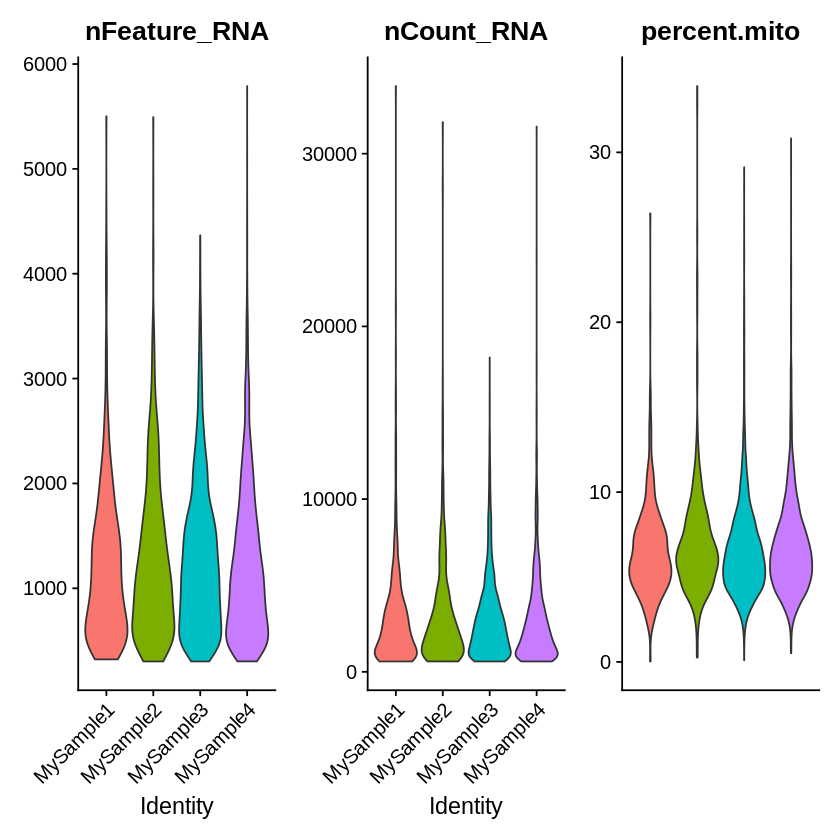

In [13]:
## add mitochondrial content 
## (This will be dependent on what mitochondrial gene names are for your particular reference genome)
obj[["percent.mito"]] <- PercentageFeatureSet(obj, pattern = "^MT-")
mito.genes <- grep("^MT\\.", rownames(obj@assays$RNA), value = T)
mito.genes <- c(mito.genes, grep("^MT-", rownames(obj@assays$RNA), value = T))

## plot the QC metrics in a violin plot
VlnPlot(obj, features = c("nFeature_RNA", "nCount_RNA", "percent.mito"),  
        pt.size = 0, ncol = 3) + 
  theme(axis.title.x = element_blank(),
        axis.text.x=element_blank(),  
        axis.ticks.x=element_blank())


###### **1.4.1.2 QC - Scatter Plots** ######

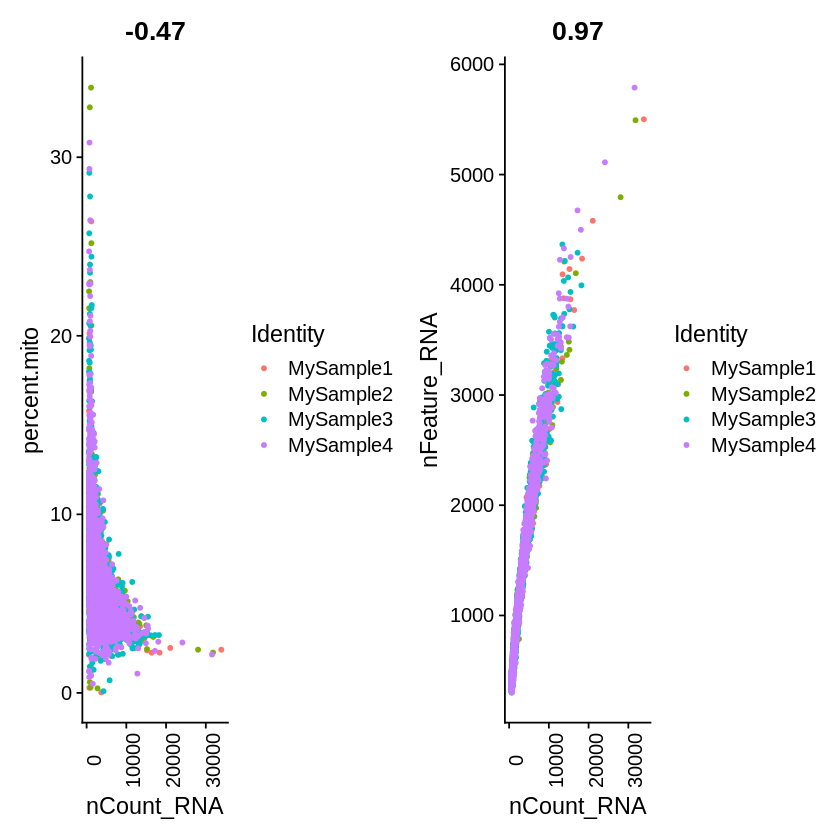

In [14]:
## plot scatter QC 
plot1 <- FeatureScatter(obj, feature1 = "nCount_RNA", feature2 = "percent.mito") + 
  theme(axis.text.x = element_text(angle = 90))
plot2 <- FeatureScatter(obj, feature1 = "nCount_RNA", feature2 = "nFeature_RNA") + 
  theme(axis.text.x = element_text(angle = 90))

plot1 + plot2

###### **1.4.1.3 QC - QC Metrics by Sample** ######
Use the qc_metrics_sample function below to obtain a table containing quality metrics for each sample. Rerun this function every time you remove or subset cells, or change the gene/threshold parameters.



In [15]:
# Load Total read info
totReads.df<- NULL
for (sample in sampleslist){
  sampleqcinfo<- read.table(samplesFile[grep(sample,samplesFile)], sep = "\t")
  specs<- sampleqcinfo$V1
  totReads.df <- as.data.frame(cbind(totReads.df,sampleqcinfo[,2]))
  row.names(totReads.df) <- specs
  }
colnames(totReads.df)<- sampleslist

qc_metrics_sample<- function(obj){
  
  I=obj@meta.data$orig.ident
  Reads=obj@meta.data$ExonReads
  ReadsM=obj@meta.data$reads.mapped
  ReadsT=obj@meta.data$reads.Total
  trans=obj@meta.data$nCount_RNA
  Genes=obj@meta.data$nFeature_RNA
  Mito=obj@meta.data$percent.mito
  Complexity=obj@meta.data$Complexity
  
  nSamples=length(sampleslist)
  readEC=vector(mode="double",length=nSamples)
  readsTot=totReads.df
  readsTotalSamples=colnames(readsTot)
  names(readEC)=sampleslist
  readTC=readEC
  readMC=readEC
  transC=readEC
  geneC=readEC
  mitoC=readEC
  nCells=readEC
  compl=readEC
  readsCellTotal=readEC
  readsSampleTotal=readEC
  FracCellReads=readEC
  readsSampleMapped=readEC
  readsSampleFiltered=readEC
  readsSampleExon=readEC
  percExon=readEC
  percFilt=readEC
  nF=readEC
  r=readEC
  v1=readEC
  v2=readEC
  v3=readEC
  date=readEC
  sT=readEC
  DS=readEC
  G=readEC
  T=readEC
  BC=readEC
  seqsat=readEC
  sampleName=readEC
  sampleGroup=readEC

  for (x in 1:nSamples) {
      readTC[x]=median(ReadsT[is.na(match(I,sampleslist[x]))==0])
      readEC[x]=median(Reads[is.na(match(I,sampleslist[x]))==0])
      readMC[x]=median(ReadsM[is.na(match(I,sampleslist[x]))==0])
      transC[x]=median(trans[is.na(match(I,sampleslist[x]))==0])
      geneC[x]=median(Genes[is.na(match(I,sampleslist[x]))==0])
      mitoC[x]=median(Mito[is.na(match(I,sampleslist[x]))==0])
      compl[x]=median(Complexity[is.na(match(I,sampleslist[x]))==0])
      nCells[x]=sum(is.na(match(I,sampleslist[x]))==0)
      readsCellTotal[x]=sum(ReadsT[is.na(match(I,sampleslist[x]))==0])
      
      sampleName[x]=sampleslist[x]
      sampleGroup[x]=groupslist[x]
      
      readsSampleTotal[x]=readsTot[1,is.na(match(readsTotalSamples,sampleslist[x]))==0]
      FracCellReads[x]=readsCellTotal[x]/readsSampleTotal[x]
      readsSampleMapped[x]=readsTot[3,is.na(match(readsTotalSamples,sampleslist[x]))==0]
      readsSampleFiltered[x]=readsTot[2,is.na(match(readsTotalSamples,sampleslist[x]))==0]
      readsSampleExon[x]=readsTot[4,is.na(match(readsTotalSamples,sampleslist[x]))==0]
      percExon[x]=readEC[x]/readTC[x]*100
      percFilt[x]=readsSampleFiltered[x]/readsSampleTotal[x]
      date[x]=gsub("-","",Sys.Date())
      G[x]=nGeneI
      T[x]=nTranI
      seqsat[x]=1-(sum(trans[is.na(match(I,sampleslist[x]))==0] / sum(ReadsM[is.na(match(I,sampleslist[x]))==0])))
  }

  clustInfo=data.frame(date,sampleName,sampleGroup,G, T, readTC,
                       readMC,readEC,transC,geneC,mitoC,nCells,
                       compl,readsSampleTotal,readsSampleFiltered,
                       readsSampleMapped,readsSampleExon,readsCellTotal,
                       FracCellReads,percExon,percFilt, seqsat)
  
  colnames(clustInfo)=c("AnalysisDate", "SampleID", "Group", "GeneThreshold",
                        "TranscriptThreshold", "TotalReads", "MappedReads",
                        "ExonReads", "nTrans", "nGenes", "percMito" ,"nCells",
                        "Complexity",  "SampleTotalReads", "SampleFilteredReads",
                        "SampleMappedReads", "SampleExonReads", "HQCellsTotalReads",
                        "FracReadsHQCells", "PctExon", "FracPassFilter", "SeqSat")
  
  write.table(clustInfo,"SamplesMetrics.txt",sep="\t",col.names=NA)
  
  return(clustInfo)
}

sample_metrics<- qc_metrics_sample(obj)

datatable(sample_metrics)

HTML widgets cannot be represented in plain text (need html)

###### **1.4.1.4 QC - Sequencing Plots** ######

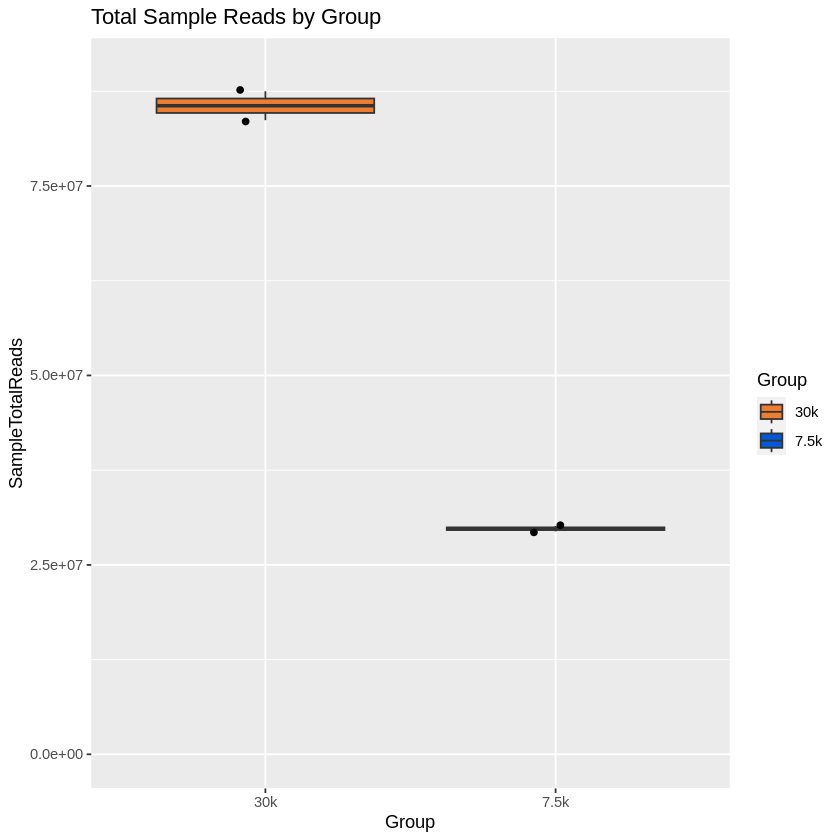

In [16]:
colors=rep(c("#ED7D30","#0058D4", "#7D3C98", "#F4D03F", "#16A085", "#721236", 
             "#A0CBE8", "#FFBE7D", "#59A14F", "#FF9D9A", "#79706E", "#8CD17D", 
             "#499894", "#BAB0AC", "#D37295", "#FABFD2", "#B07AA1"),5)

p <- ggplot(sample_metrics, aes(Group, SampleTotalReads)) + 
  ggtitle("Total Sample Reads by Group") 

# calculate axis limits for plots
d=floor(log(max(sample_metrics$SampleTotalReads),10))
yL=ceiling(max(sample_metrics$SampleTotalReads)/10^d)*10^d

p + geom_boxplot(outlier.shape = NA, aes(fill = Group) ) + 
  scale_fill_manual(values=colors) + 
  geom_jitter(width = 0.2) + 
  ylim(c(0,yL)) 

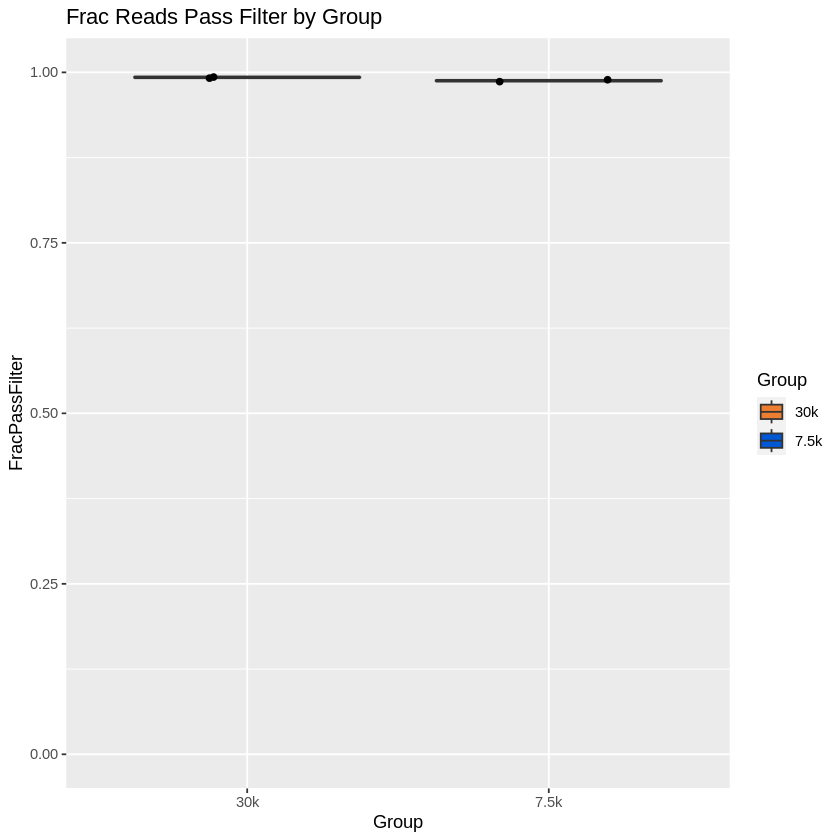

In [17]:
p <- ggplot(sample_metrics, aes(Group, FracPassFilter)) + 
  ggtitle("Frac Reads Pass Filter by Group")

p + geom_boxplot(outlier.shape = NA, aes(fill = Group) ) + 
  scale_fill_manual(values=colors) + 
  geom_jitter(width = 0.2) + 
  ylim(c(0,1))

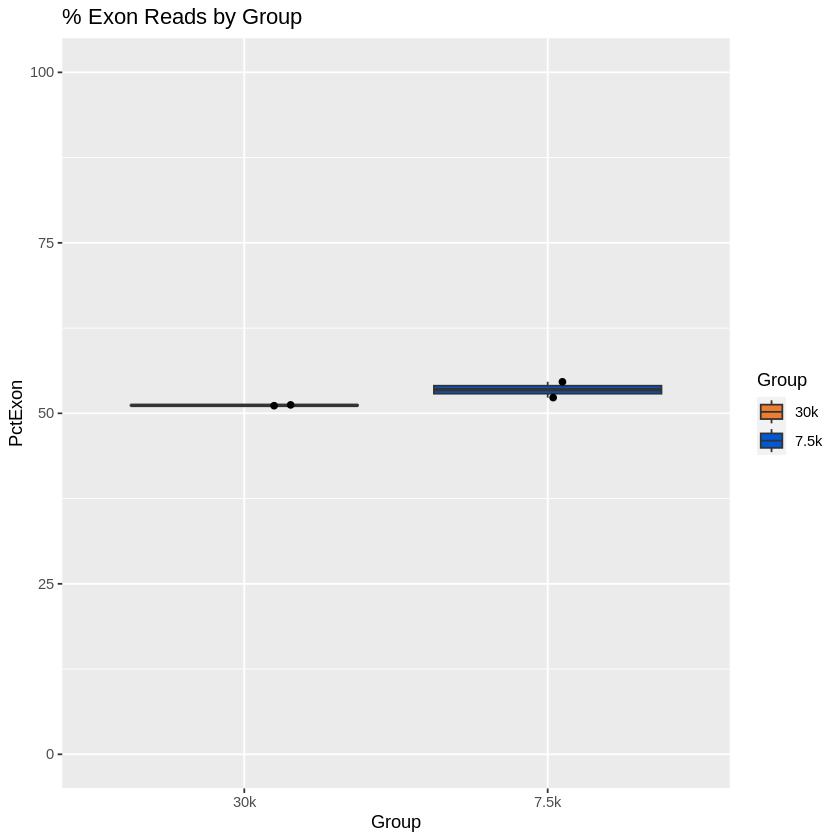

In [18]:
p <- ggplot(sample_metrics, aes(Group, PctExon)) + 
  ggtitle("% Exon Reads by Group")

p + geom_boxplot(outlier.shape = NA, aes(fill = Group) ) + 
  scale_fill_manual(values=colors) + 
  geom_jitter(width = 0.2) + 
  ylim(c(0,100)) 


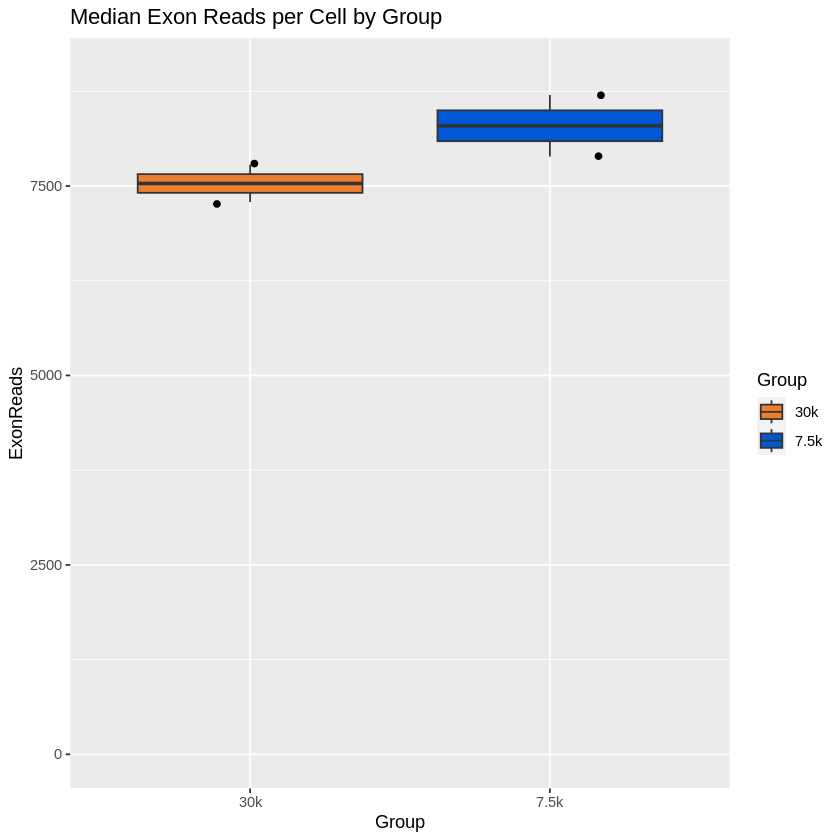

In [19]:
p <- ggplot(sample_metrics, aes(Group, ExonReads)) + 
  ggtitle("Median Exon Reads per Cell by Group")

# calculate axis limits for plots
d=floor(log(max(sample_metrics$ExonReads),10))
yL=ceiling(max(sample_metrics$ExonReads)/10^d)*10^d

p + geom_boxplot(outlier.shape = NA, aes(fill = Group) ) + 
  scale_fill_manual(values=colors) + 
  geom_jitter(width = 0.2) + 
  ylim(c(0,yL)) 


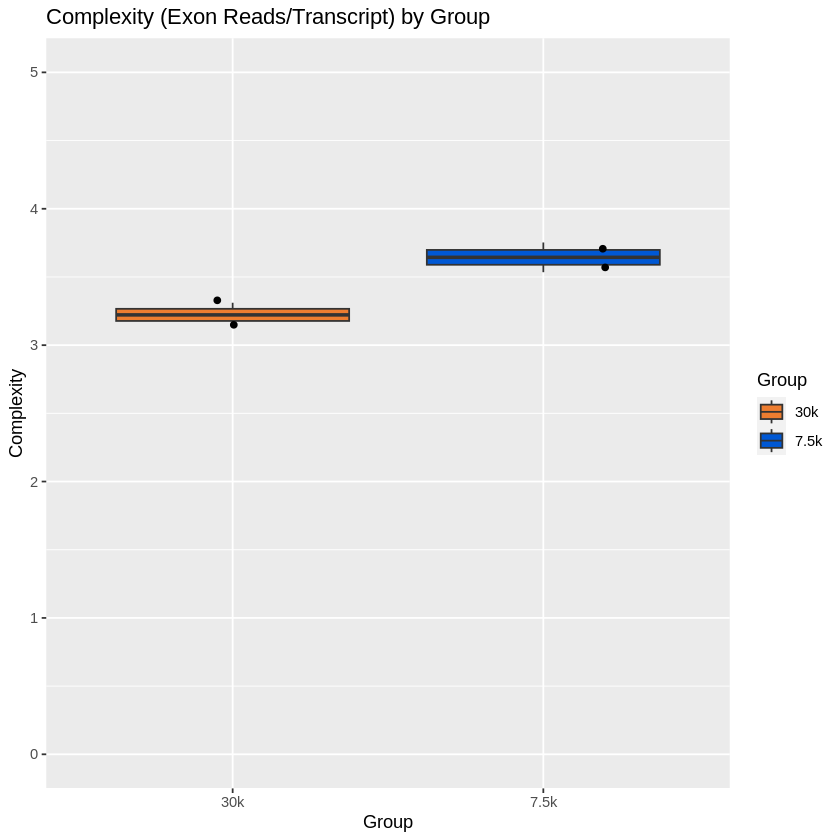

In [20]:
p <- ggplot(sample_metrics, aes(Group, Complexity)) + 
  ggtitle("Complexity (Exon Reads/Transcript) by Group")

# calculate axis limits for plots
yL=5*ceiling(max(sample_metrics$Complexity)/5)

p + geom_boxplot(outlier.shape = NA, aes(fill = Group) ) + 
  scale_fill_manual(values=colors) + 
  geom_jitter(width = 0.2) + 
  ylim(c(0,yL)) 

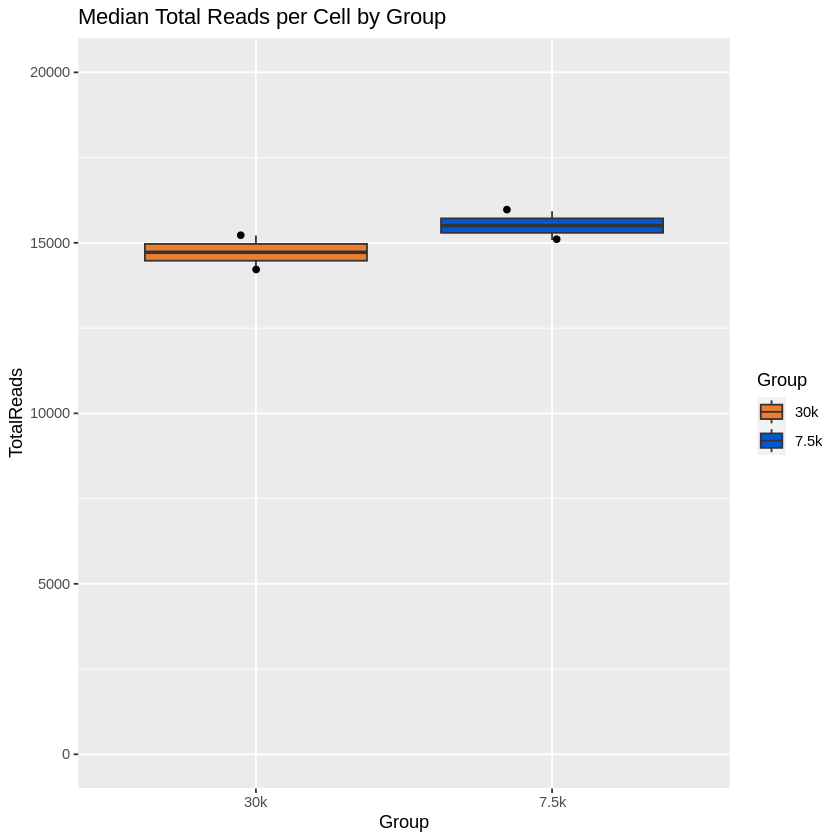

In [21]:
p <- ggplot(sample_metrics, aes(Group, TotalReads)) + 
  ggtitle("Median Total Reads per Cell by Group")

# calculate axis limits for plots
d=floor(log(max(sample_metrics$TotalReads),10))
yL=ceiling(max(sample_metrics$TotalReads)/10^d)*10^d

p + geom_boxplot(outlier.shape = NA, aes(fill = Group) ) + 
  scale_fill_manual(values=colors) + 
  geom_jitter(width = 0.2) + 
  ylim(c(0,yL)) 

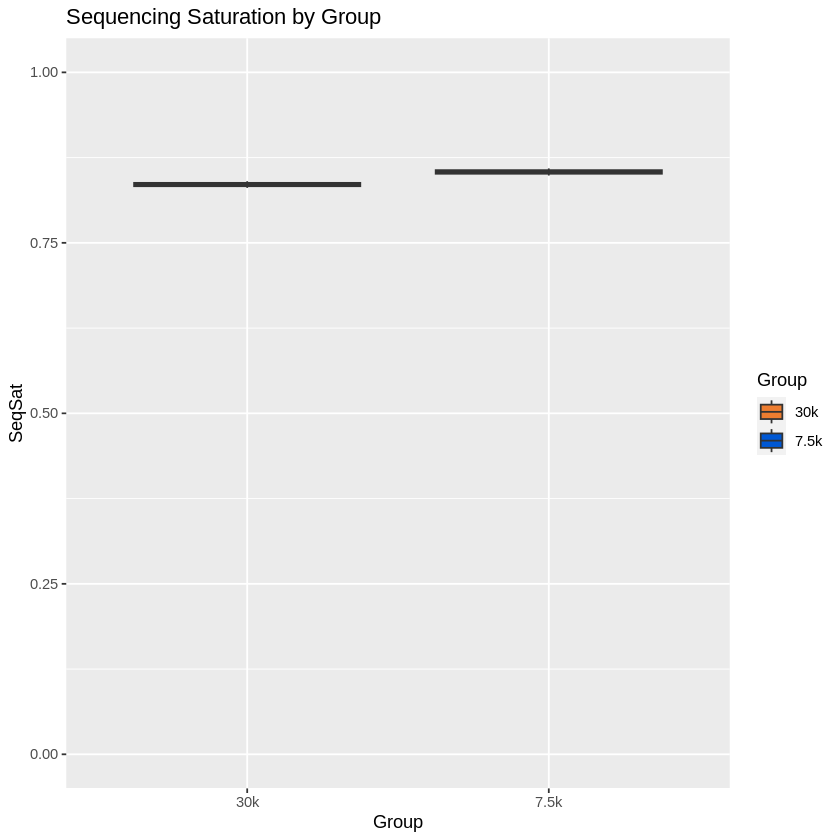

In [22]:
p <- ggplot(sample_metrics, aes(Group, SeqSat)) + 
  ggtitle("Sequencing Saturation by Group")

yL=100

p + geom_boxplot(outlier.shape = NA, aes(fill = Group) ) + 
  scale_fill_manual(values=colors) + 
  ylim(c(0,1)) 


##### **1.4.2 Cell Recovery** #####
Using your sample metrics table, make plots to display cell/gene/transcript recovery. In this example, only 1/8 of the HIVE was sequenced, so cell recovery is 1/8 of what would be expected for these samples.

Here are a few things to look for in your data.

Median Genes by Group: > 800. This number is sample dependent. It is usually higher for cell lines and lower for samples that contain granulocytes.

Median Transcripts by Group: > 1200. This number is sample dependent. It is usually higher for cell lines and lower for samples that contain granulocytes.

Percent Mito by Group: < 20%.

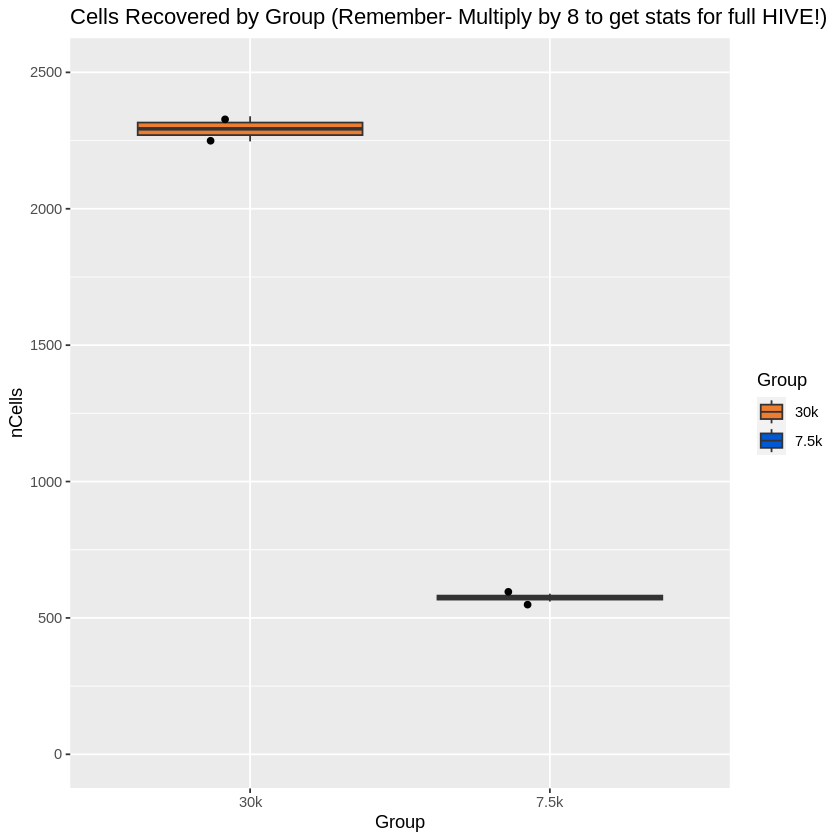

In [23]:
p <- ggplot(sample_metrics, aes(Group, nCells)) + 
  ggtitle("Cells Recovered by Group (Remember- Multiply by 8 to get stats for full HIVE!)")

# calculate axis limits for plots
yL=500*ceiling(max(sample_metrics$nCells/500))

p + geom_boxplot(outlier.shape = NA, aes(fill = Group) ) + 
  scale_fill_manual(values=colors) + 
  geom_jitter(width = 0.2) + 
  ylim(c(0,yL))

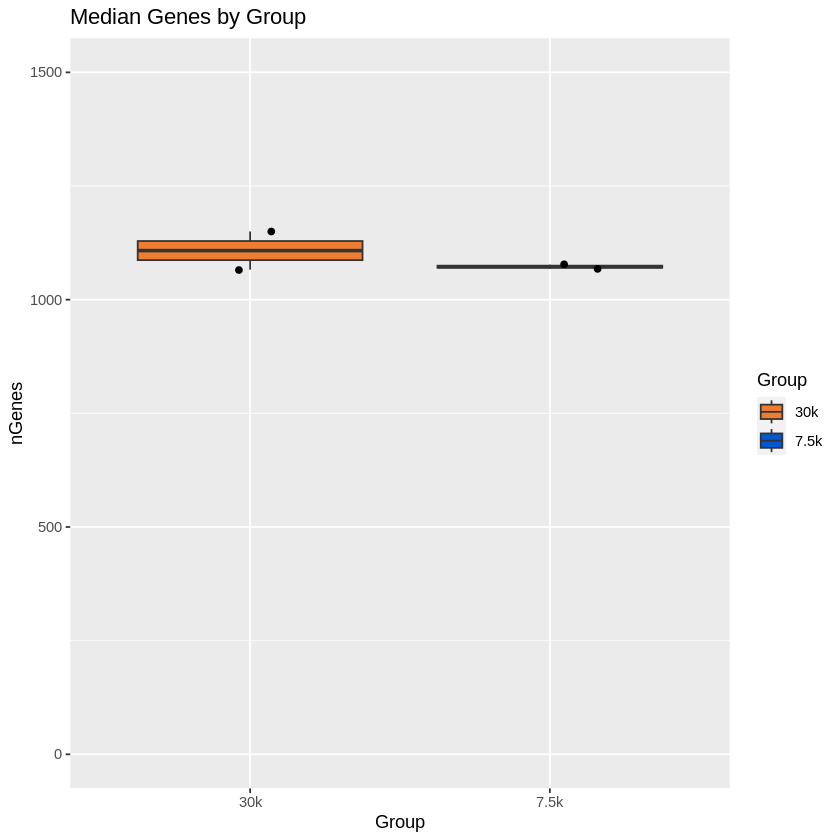

In [24]:
p <- ggplot(sample_metrics, aes(Group, nGenes)) + 
  ggtitle("Median Genes by Group")

# calculate axis limits for plots
yL=500*ceiling(max(sample_metrics$nGenes)/500) 

p + geom_boxplot(outlier.shape = NA, aes(fill = Group) ) + 
  scale_fill_manual(values=colors) + 
  geom_jitter(width = 0.2) + 
  ylim(c(0,yL)) 

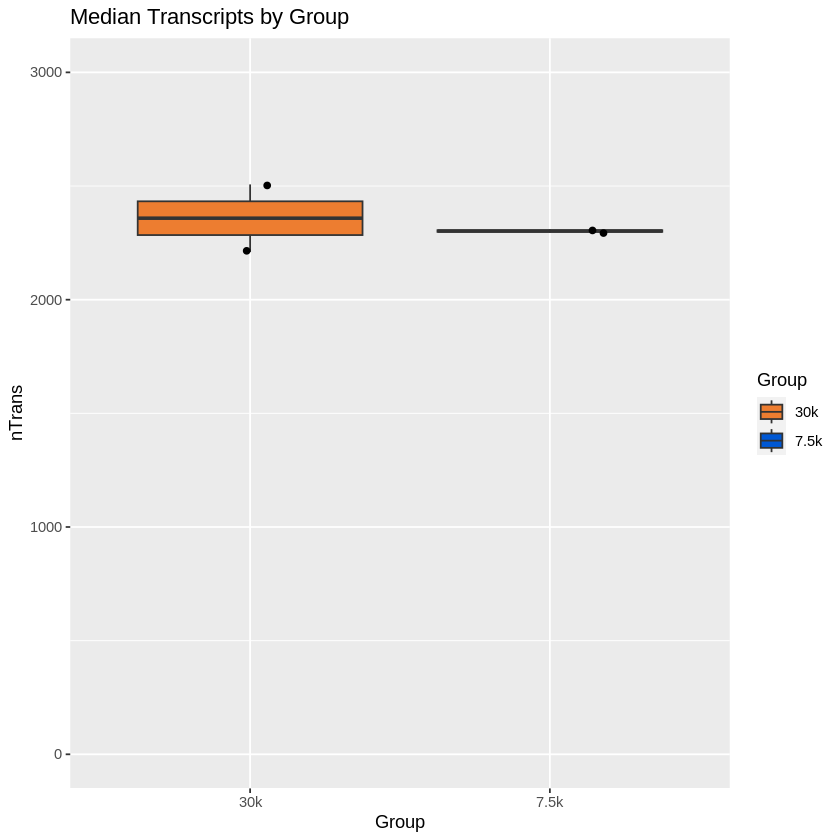

In [25]:
p <- ggplot(sample_metrics, aes(Group, nTrans)) + 
  ggtitle("Median Transcripts by Group")

# calculate axis limits for plots
yL=500*ceiling(max(sample_metrics$nTrans)/500) 

p + geom_boxplot(outlier.shape = NA, aes(fill = Group) ) + 
  scale_fill_manual(values=colors) + 
  geom_jitter(width = 0.2) + 
  ylim(c(0,yL)) 

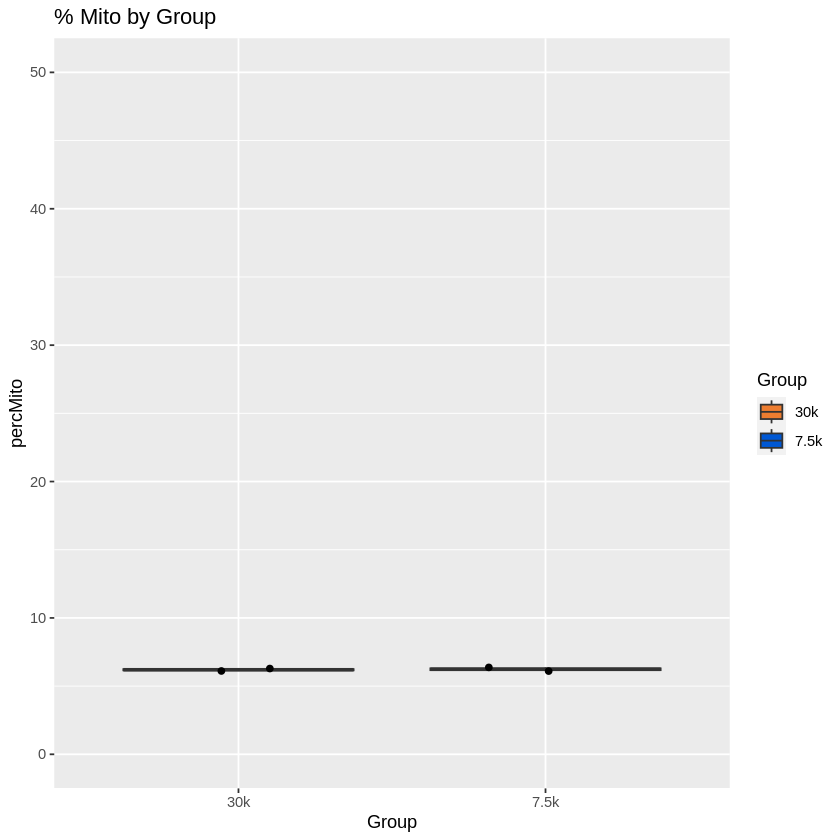

In [26]:
p <- ggplot(sample_metrics, aes(Group, percMito)) + 
  ggtitle("% Mito by Group")

yL=50

p + geom_boxplot(outlier.shape = NA, aes(fill = Group) ) + 
  scale_fill_manual(values=colors) + 
  geom_jitter(width = 0.2) + 
  ylim(c(0,yL)) 

#### **1.5 Dimensionality Reduction** ####

In [28]:
## Dimensionality Reduction
obj <- NormalizeData(obj)
obj <- ScaleData(obj)
obj <- FindVariableFeatures(obj, selection.method = "vst", nfeatures = 2000)
obj <- RunPCA(obj, verbose = FALSE)
obj <- RunUMAP(obj, dims=1:30,verbose = FALSE)
obj <- FindNeighbors(obj,verbose = FALSE)
obj <- FindClusters(obj, verbose = FALSE)
obj <- BuildClusterTree(obj,reorder=TRUE,reorder.numeric=TRUE)
obj$seurat_clusters <- obj$tree.ident

#Run SCTransform if percent.mito is present in metadata
if (is.null(mito.genes)==FALSE){
    obj <- SCTransform(obj, vars.to.regress = "percent.mito", verbose = FALSE)
} else {
    obj <- SCTransform(obj, verbose = FALSE)
}
obj <- RunPCA(obj, verbose = FALSE)
obj <- RunUMAP(obj, dims=1:18,verbose = FALSE)
obj <- FindNeighbors(obj,verbose = FALSE)
obj <- FindClusters(obj, verbose = FALSE)
obj <- BuildClusterTree(obj,reorder=TRUE,reorder.numeric=TRUE)
obj$seurat_clusters <- obj$tree.ident

Normalizing layer: counts.MySample1

Normalizing layer: counts.MySample2

Normalizing layer: counts.MySample3

Normalizing layer: counts.MySample4

Centering and scaling data matrix

Finding variable features for layer counts.MySample1

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -2.4472”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.30103”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  5.2192e-16”
Finding variable features for layer counts.MySample2

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -2.4691”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.30103”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“re

ERROR: Error: Cluster tree functionality requires 'ape' please install with 'install.packages('ape')'


##### **1.5.1 UMAP Plots** #####
###### **1.5.1.1 Clusters** ######

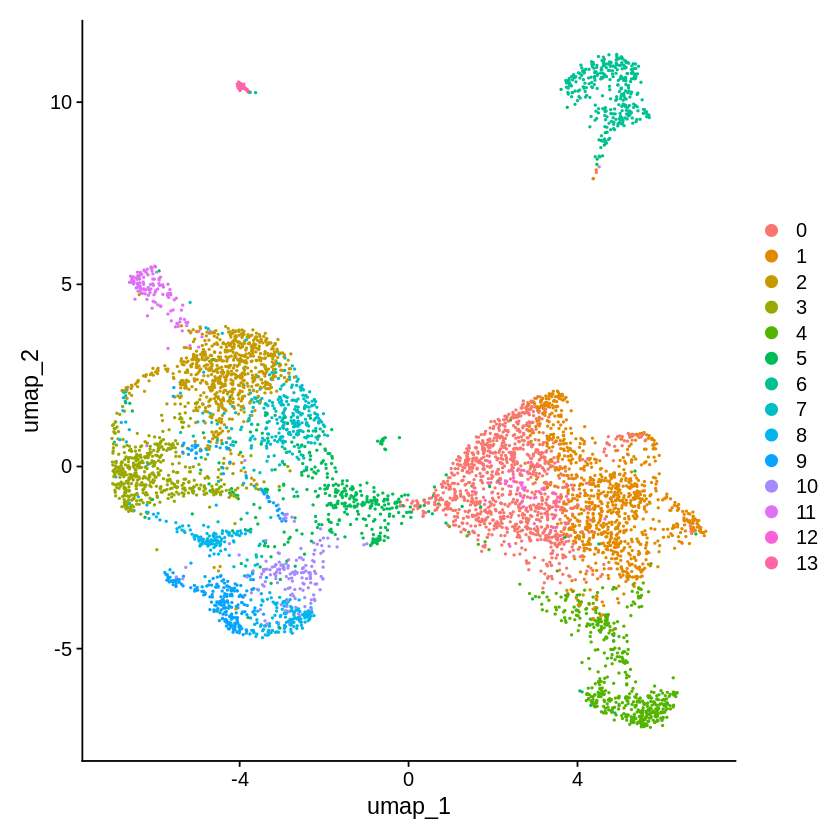

In [29]:
DimPlot(obj, reduction="umap")

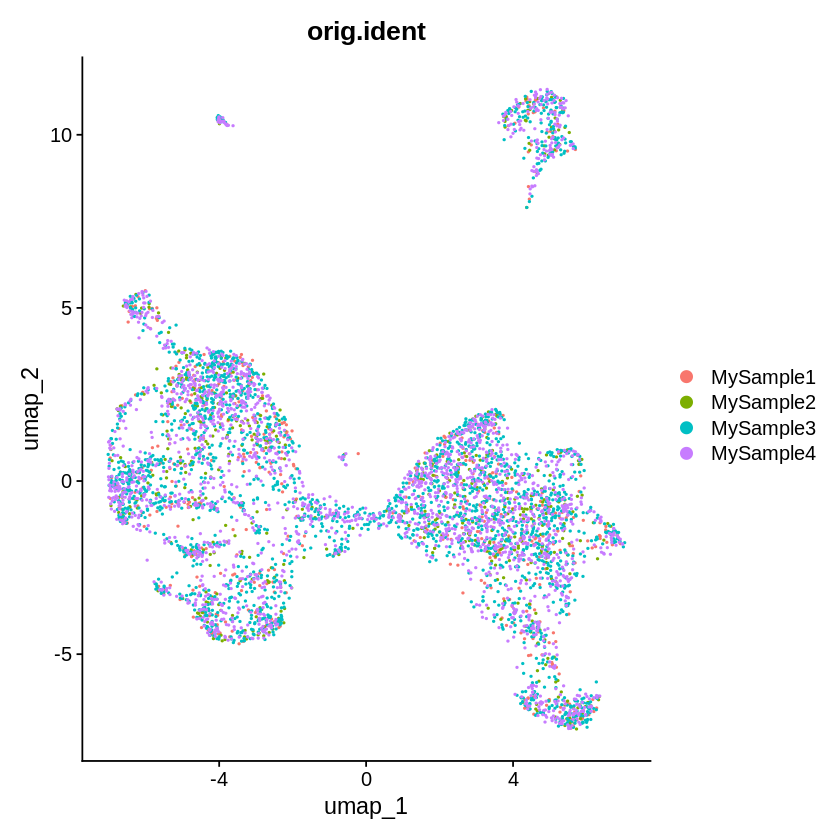

In [30]:
#The UMAP can be colored or split by sample or group

DimPlot(obj, reduction="umap", group.by = "orig.ident")

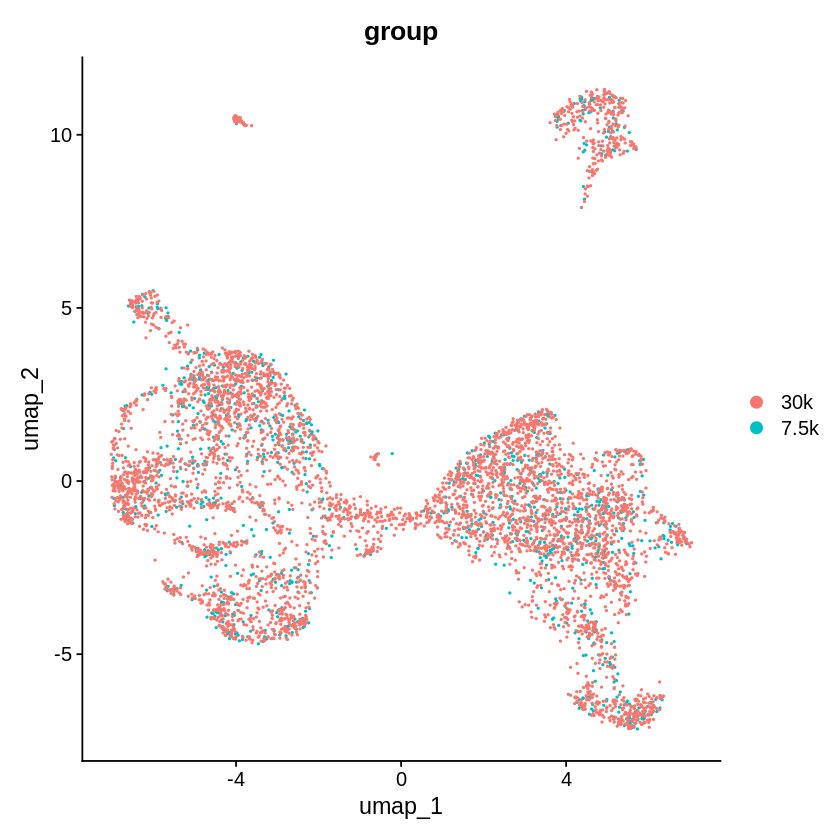

In [31]:
DimPlot(obj, reduction="umap", group.by = "group")

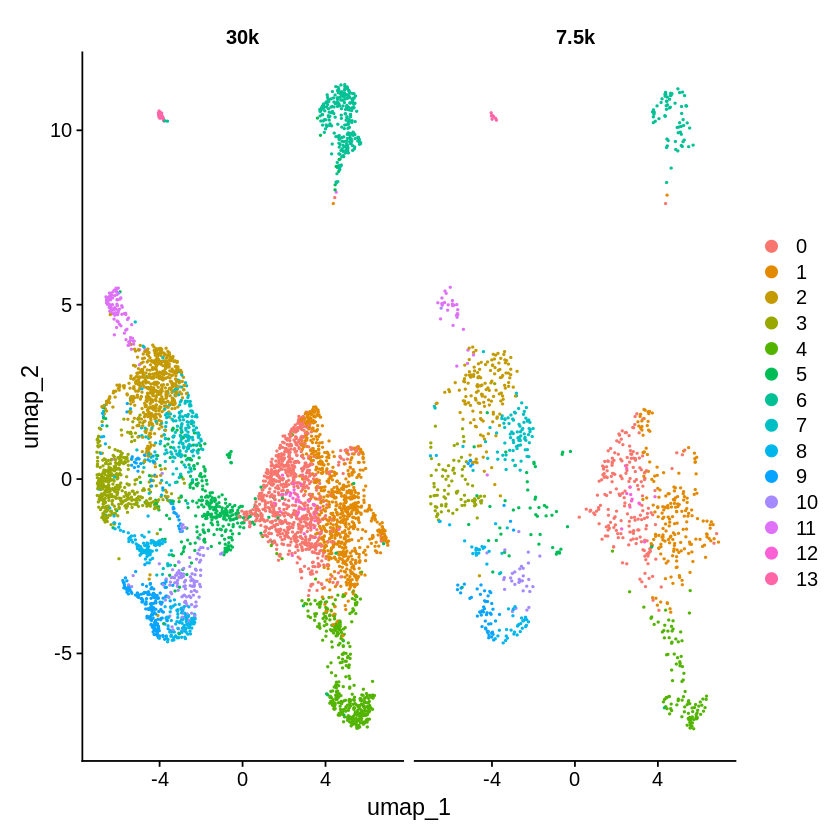

In [32]:
DimPlot(obj, reduction="umap", split.by = "group")

###### **1.5.1.2 Cell Features** ######
Feature plots can be used to plot most variables in your dataset. You can use this plot for genes and transcripts, but can also use these plots to plot expression of your favorite gene!

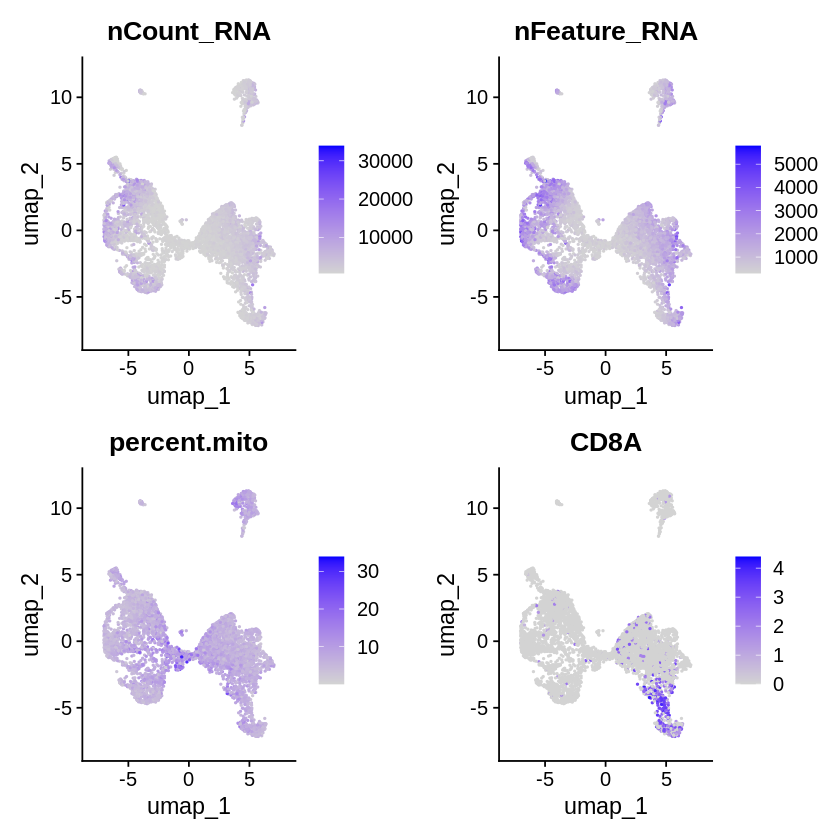

In [33]:
features <- c("nCount_RNA", "nFeature_RNA","percent.mito","CD8A")
FeaturePlot(obj, features = features)

##### **1.5.2 Violin Plot** #####
Here we look at the number of transcripts detected in each cell, broken out by cluster. Once clustering is performed, the “identity” of each cell barcode is its cluster number, which is why this graph is separated by cluster. You can change identities of the cell at any time (See the next section on how to change the identity to “cell type”)

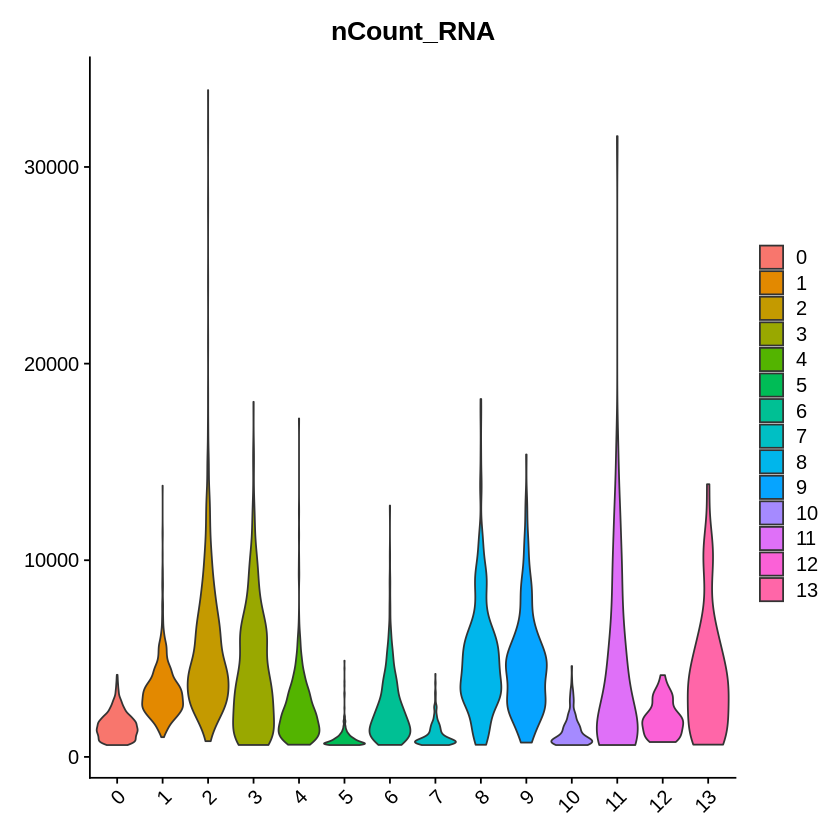

In [34]:
VlnPlot(obj, features = 'nCount_RNA', pt.size = 0) +
  theme(axis.title.x = element_blank())

##### **1.5.3 scType - Cell Type Identification** #####
For a preliminary cell type ID, we use scType (https://github.com/IanevskiAleksandr/sc-type). This annotator works best for human and mouse samples but may also apply to other reference genomes.

In [41]:
# Set the working directory
setwd("/media/asus/275dd380-2319-4638-bcdd-5f65b2b1d4b5/CHRF_Project_Data/Single_Cell/Honeycomb_Biotechnologies/Data_Analysis/3_Additional_Analysis_Resources/4_Seurat_Analysis_Tutorial")

# Source the local R script files
source("sc-type/R/gene_sets_prepare.R")
source("sc-type/R/sctype_score_.R")
source("sc-type/R/auto_detect_tissue_type.R")

# Make sure your Seurat object 'obj' is already loaded here
# If not, load or create your Seurat object 'obj'

# Scale the data in the Seurat object
# obj <- ScaleData(obj, features = rownames(obj@assays$RNA))

# Load the marker genes and predict the dataset's tissue type
db_ = "./ScTypeDB_full.xlsx"
tissue_guess = auto_detect_tissue_type(path_to_db_file = db_, 
                                       seuratObject = obj, 
                                       scaled = TRUE, 
                                       assay = "RNA")


[1] "Checking...Immune system"


Warning message in checkGeneSymbols(markers_all):
“Human gene symbols should be all upper-case except for the 'orf' in open reading frames. The case of some letters was corrected.”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'as.matrix': no slot of name "scale.data" for this object of class "Assay5"


In [42]:
obj <- ScaleData(obj, features = rownames(obj))


Centering and scaling data matrix



In [43]:
## Download the reference scripts and mar
source("https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/R/gene_sets_prepare.R")
source("https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/R/sctype_score_.R")
source("https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/R/auto_detect_tissue_type.R")

# load the marker genes for all tissue types and have scType predict the right dataset
db_ = "https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/ScTypeDB_full.xlsx";
tissue_guess = auto_detect_tissue_type(path_to_db_file = db_, 
                                       seuratObject = obj, 
                                       scaled = TRUE, 
                                       assay = "RNA")

[1] "Checking...Immune system"


Warning message in checkGeneSymbols(markers_all):
“Human gene symbols should be all upper-case except for the 'orf' in open reading frames. The case of some letters was corrected.”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'as.matrix': no slot of name "scale.data" for this object of class "Assay5"


In [37]:
tissue<- tissue_guess[1,1]
# prepare gene sets
gs_list = gene_sets_prepare(db_, tissue)

es.max = sctype_score(scRNAseqData = obj[["RNA"]]@scale.data, 
                      scaled = TRUE, 
                      gs = gs_list$gs_positive, 
                      gs2 = gs_list$gs_negative) 

# merge by cluster
cL_resutls = do.call("rbind", lapply(unique(obj@meta.data$seurat_clusters), function(cl){
    es.max.cl = sort(rowSums(es.max[ ,rownames(obj@meta.data[obj@meta.data$seurat_clusters==cl, ])]), decreasing = !0)
    head(data.frame(cluster = cl, type = names(es.max.cl), scores = es.max.cl, ncells = sum(obj@meta.data$seurat_clusters==cl)), 10)
}))
sctype_scores = cL_resutls %>% group_by(cluster) %>% top_n(n = 1, wt = scores)  

# set low-confident (low ScType score) clusters to "unknown"
sctype_scores$type[as.numeric(as.character(sctype_scores$scores)) < sctype_scores$ncells/4] = "Unknown"
print(sctype_scores[,1:3])

ERROR: Error in eval(expr, envir, enclos): object 'tissue_guess' not found


In [ ]:
# save old idents for reference
obj[["old.ident"]] <- Idents(object = obj)


obj@meta.data$customclassif = ""
        for(j in unique(sctype_scores$cluster)){
            cl_type = sctype_scores[sctype_scores$cluster==j,]; 
            obj@meta.data$customclassif[obj@meta.data$seurat_clusters == j] = as.character(cl_type$type[1])
        }
        
obj[["cell_type"]]<- obj$customclassif
write.table(sctype_scores, file = "sctype_scores.txt", quote = F, sep = "\t")

## Change the cell identity to "cell-type"
Idents(obj)<- obj$cell_type

## Visualise as umap
DimPlot(obj, reduction="umap", group.by = "cell_type")

In [ ]:
## display a table of the results
datatable(sctype_scores)
Show 
10
 entriesSearch:


#### **1.6 Differential Gene Expression Analysis** ####
The table below shows the the genes expressed in each cluster versus. all other clusters. You can change the Idents to change the grouping for the marker gene analysis.

- > p_val: the p value from the Wilcoxon rank sum test
- > avg_log2FC: log2 fold change
- > pct.1: percent of cells expressing the indicated gene in the cluster specified in the “cluster” column
- > pct.2: percent of all other cells in the other clusters that express the indicated gene
- > p_val_adj: Bonferroni corrected p-values
- > cluster: the specific cluster that is being evaluated

In [ ]:
DefaultAssay(obj) <- "RNA"
Idents(obj)<- obj$seurat_clusters
markers <- FindAllMarkers(obj, 
                          logfc.threshold = 0.25,
                          test.use = "wilcox",
                          min.pct = 0.25)
datatable(markers)

#### **1.7 Save R environment** ####
Consider saving your Seurat object and other variables for future use with the following code.

In [ ]:
# Fill in the name of the data set below

save(obj, nGeneI, nTranI, sampleslsit, groupslist, totReads.df, markers, sctype_scores,
     file = "Name_of_Dataset.Rdata")